# Feature representations

In this notebook, we will learn three things:

- Why do we need feature representation?
- When are feature representation useful?
- How can we find good representations?

In [1]:
import common
import graphviz
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets
import sklearn.decomposition
import sklearn.tree

## Generate data

### Data are located on two concentric circles

The data we generate here is similar to the data set we studied in the last lecture (binary logistic regression). We create two classes of data points, located on two concentric circles. We want to classify points, categorizing wether the points belong to the inner or the outer circle.

At the same time, this classification task is very easy and very difficult. What do we mean by that? Let's see...

In [2]:
np.random.seed(501)
X, y = sklearn.datasets.make_circles(n_samples=2_000, factor=0.2, noise=0.12)

In [3]:
def scatterplot(x, title):
    plt.title(title)
    mask_1 = y == 1
    plt.scatter(x[~mask_1, 0], x[~mask_1, 1], c="darkblue", s=70, alpha=0.5)
    plt.scatter(x[mask_1, 0], x[mask_1, 1], c="darkorange", s=70, alpha=0.5)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.show()

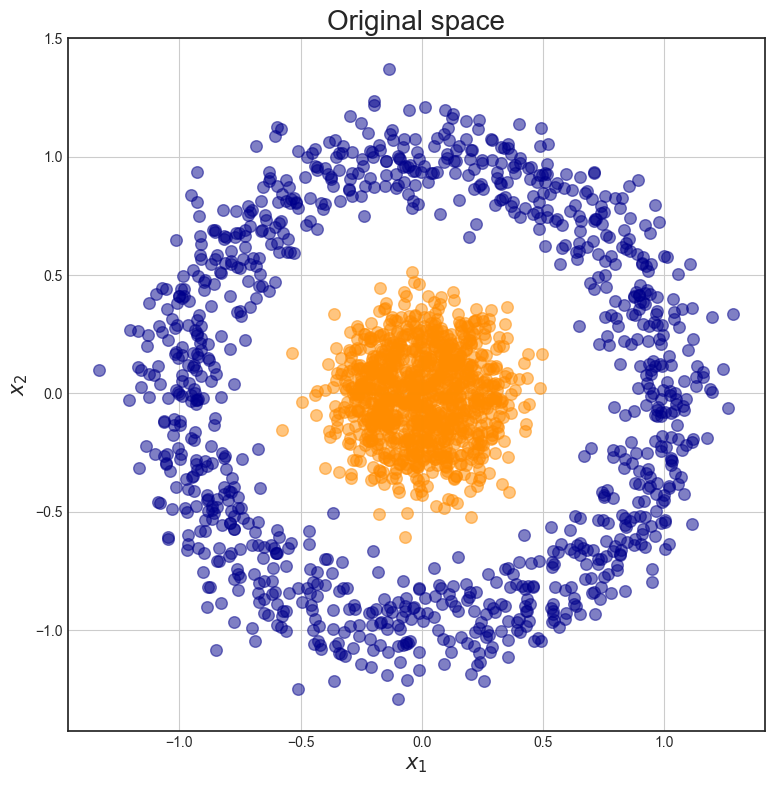

In [4]:
scatterplot(X, "Original space")

<br>
<br>

## Decision tree on original data

We first fit a decision tree to illustrate the complexity of the decision boundary between the classes located on the concentric circles. We are not interested in the model's predictive performance so we don't create a test set here.

### Fit decision tree

Note that we do not limit the tree's complexity.

In [5]:
tree = sklearn.tree.DecisionTreeClassifier(random_state=501)
tree = tree.fit(X, y)

In [6]:
print(f"tree depth = {tree.get_depth()}")
print(f"number of leaves = {tree.get_n_leaves()}")

tree depth = 7
number of leaves = 19


### Visualize decision boundary

In the context of binary classification, the decision boundary is a hyperplane that partitions a given vector space into two sets, one for each class. The classifier will classify the points on one side of the hyperplane as belonging to one class, and the points on the other side of the hyperplane as belonging to the other class.

In our simple 2D case, the hyperplane is simply a line :)

In [7]:
def plot_boundary(x, tree, plot_step=0.02, margin=0.2):

    x_min, x_max = x[:, 0].min() - margin, x[:, 0].max() + margin
    y_min, y_max = x[:, 1].min() - margin, x[:, 1].max() + margin
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
    )
    Z = tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        "", ["#00008b1A", "#ff8c001A"]
    )
    plt.contourf(xx, yy, Z, cmap=cmap)

    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")

    mask_1 = y == 1
    plt.scatter(x[~mask_1, 0], x[~mask_1, 1], c="darkblue", s=70, alpha=0.5)
    plt.scatter(x[mask_1, 0], x[mask_1, 1], c="darkorange", s=70, alpha=0.5)

    plt.show()

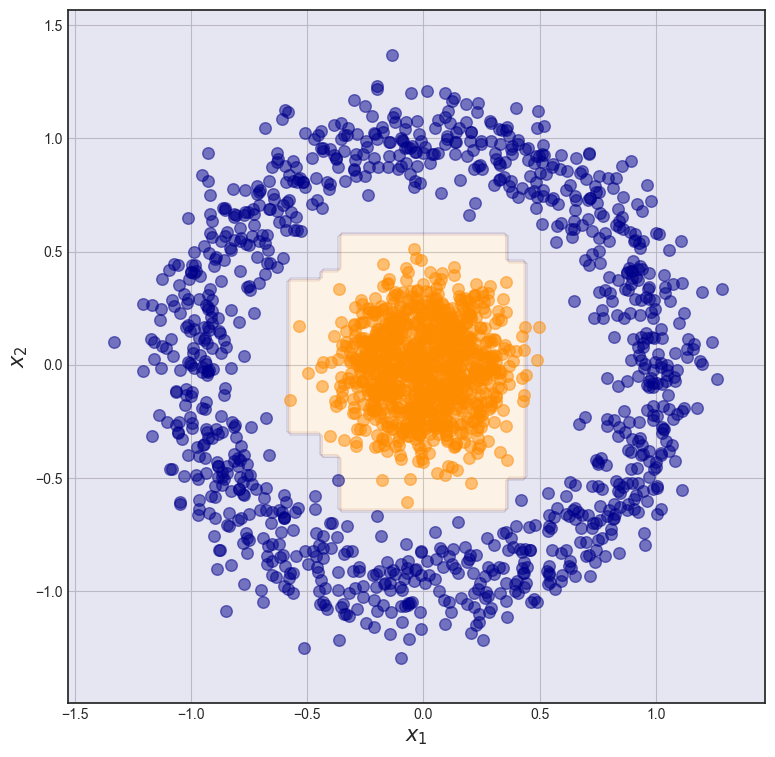

In [8]:
plot_boundary(X, tree)

### Visualize decision tree

Let's visualize all splits the tree made.

In [9]:
def plot_tree(tree):
    dot_data = sklearn.tree.export_graphviz(
        tree,
        out_file=None,
        feature_names=["x1", "x2"],
        class_names=["outer", "inner"],
        filled=True,
        rounded=True,
        special_characters=True,
    )
    return graphviz.Source(dot_data)

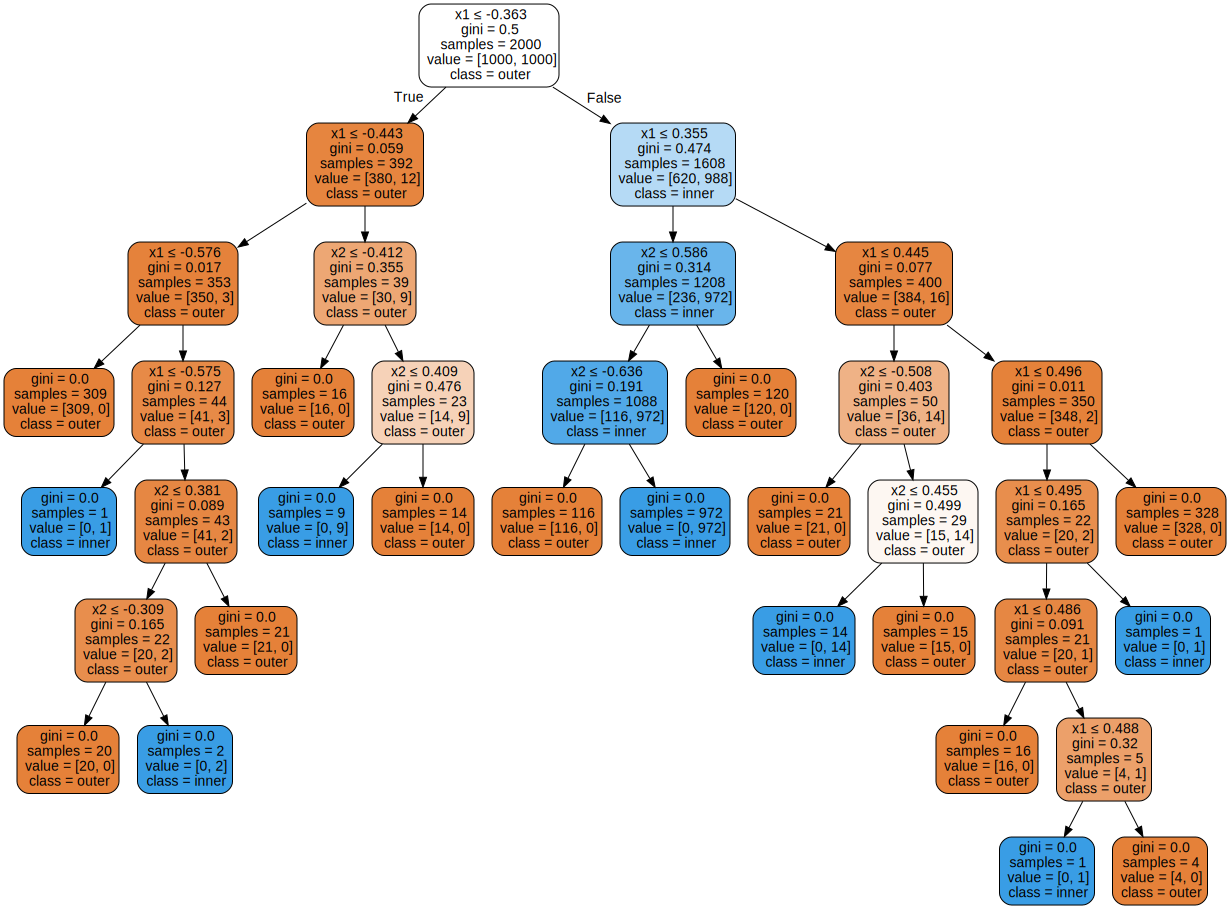

In [10]:
plot_tree(tree)

## What do you think: Was what we just did good or bad?!

<img src="https://raw.githubusercontent.com/sbstn-gbl/learning-from-big-data/master/source/_static/img/hard.gif" width="1000px">

[Check out the full clip on YouTube, it's pretty good :)](https://www.youtube.com/watch?v=ofGy1zuj2rM)

## Revisit the original feature space (and classification problem)

What would be easier than the decision boundary produced by the tree we just fitted?

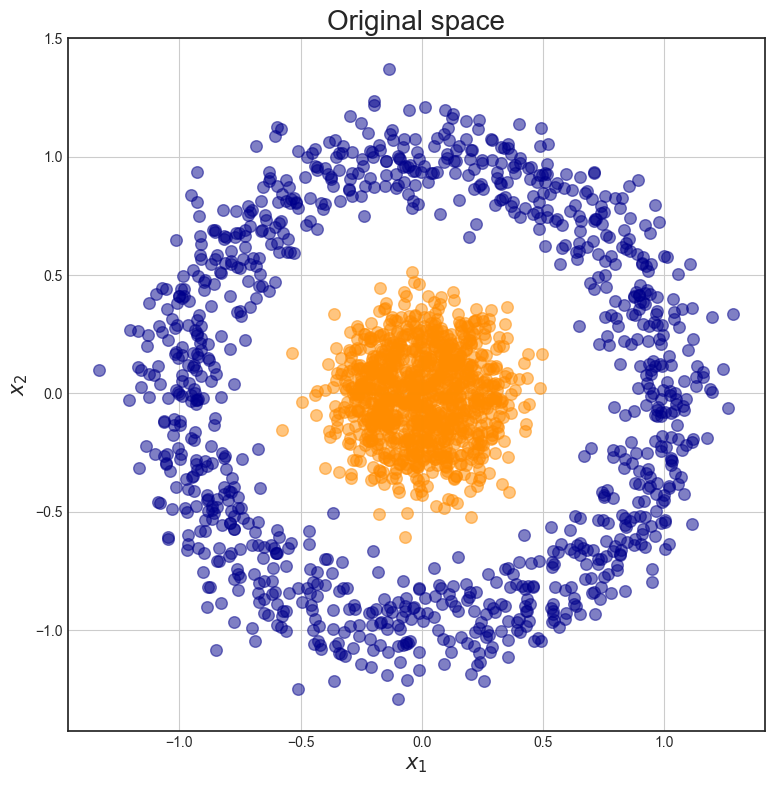

In [11]:
scatterplot(X, "Original space")

## Polar coordinate system

A "theory-driven" representation of the feature space:

<img src="https://raw.githubusercontent.com/sbstn-gbl/learning-from-big-data/master/source/_static/img/polar.png" width="300px">

In this reprsentation we replace `x` and `y` by two new 

* $\varphi$ the angle between , in $\varphi \in [0, 360)$
* $r$ the distance from origin, in $r >= 0$

In [12]:
def cartesian2polar(cartesian):
    """
    x is a 2D numpy array:
    - column 1 is cartesian dimension 1 `x`
    - column 2 is cartesian dimension 2 `y`
    """
    r = np.sqrt(cartesian[:, 0] ** 2 + cartesian[:, 1] ** 2)
    phi = np.arctan2(cartesian[:, 1], cartesian[:, 0])
    return np.column_stack((r, phi))


def polar2cartesian(polar):
    """
    x is a 2D numpy array:
    - column 1 is radius `rho`
    - column 2 is angle `theta`
    """
    x = polar[:, 0] * np.cos(polar[:, 1])
    y = polar[:, 0] * np.sin(polar[:, 1])
    return np.column_stack((x, y))

In [13]:
X_polar = cartesian2polar(X)
X_reconstructed = polar2cartesian(X_polar)
assert np.max(np.abs(X - X_reconstructed)) < 1e-12

### Plot

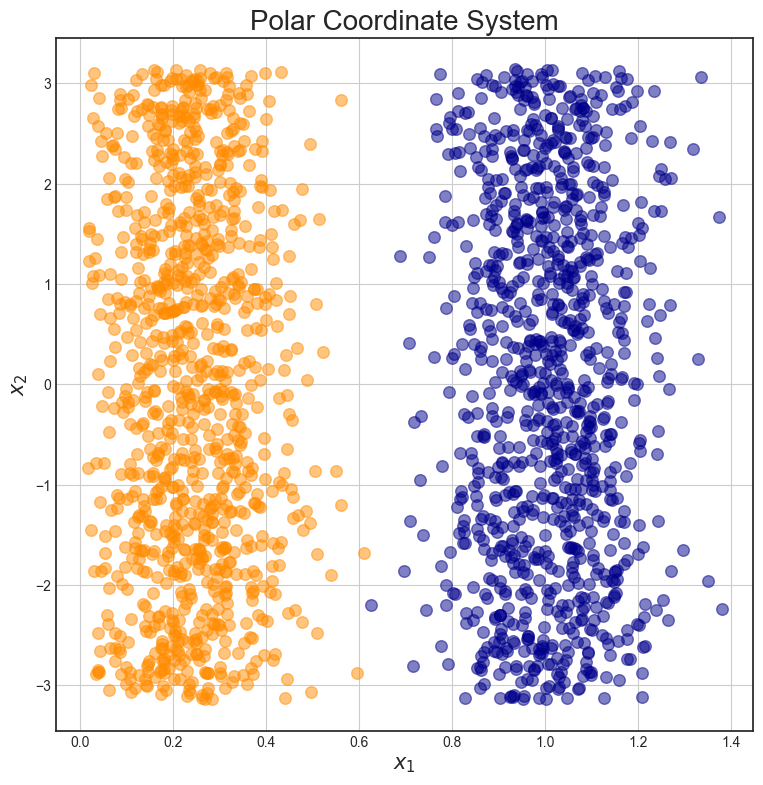

In [14]:
scatterplot(X_polar, "Polar Coordinate System")

### Fit decision tree

A decision tree is expressive enough to separate the two classes so this transformation is not necessary for building a sufficiently good classifier. However, this example shows that a much simpler model is sufficient for the transformed data.

In [15]:
tree_polar = sklearn.tree.DecisionTreeClassifier(random_state=501)
tree_polar = tree_polar.fit(X_polar, y)

In [16]:
print(f"tree depth = {tree_polar.get_depth()}")
print(f"number of leaves = {tree_polar.get_n_leaves()}")

tree depth = 1
number of leaves = 2


### Visualize decision boundary

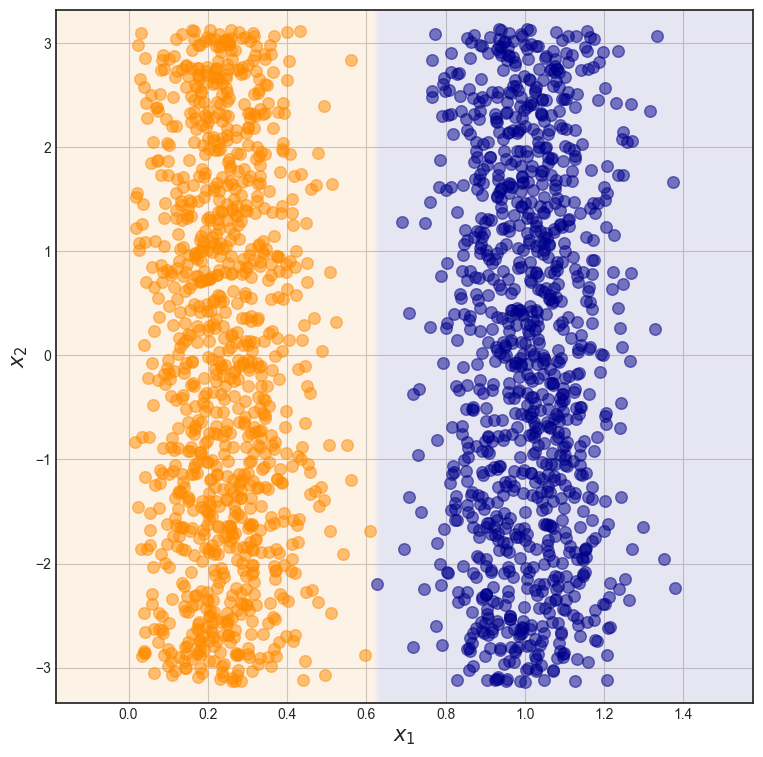

In [17]:
plot_boundary(X_polar, tree_polar)

### Visualize decision tree

A tree of depth one with only two leaf nodes suffices, all thanks to the much simpler decision boundary.

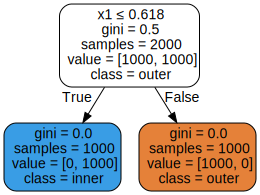

In [18]:
plot_tree(tree_polar)

<br>
<br> 

## Lessons

1. The way we represent our data has a major impact on our models and results
1. This problem was a good example for the trade-off between feature complexity and model complexity
1. The easiest and most useful way derive representations is to them on "theory"

<br>
<br>

<br>
<br>

# Self study

## Kernel PCA

This is a useful alternative to the polar coordinate system.

For more details, see [this notebook (for self study) on dimensionality reduction](../lectures/l06-3-dimensionality-reduction.ipynb).

tree depth = 1
number of leaves = 2


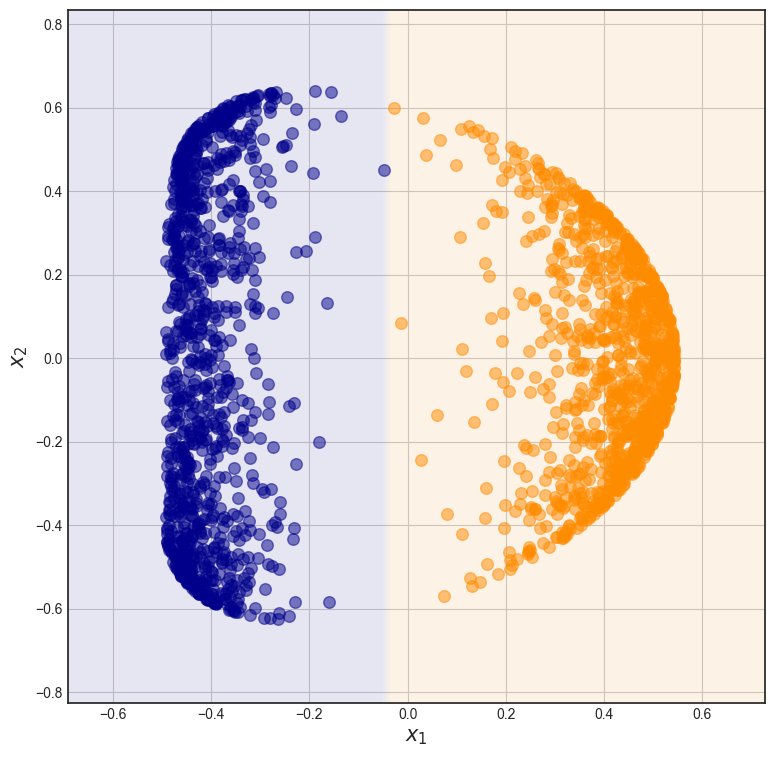

In [19]:
kpca = sklearn.decomposition.KernelPCA(
    n_components=2,
    kernel="rbf",
    gamma=2,
)
X_kpca = kpca.fit_transform(X)

tree_kpca = sklearn.tree.DecisionTreeClassifier(random_state=501)
tree_kpca = tree_kpca.fit(X_kpca, y)

print(f"tree depth = {tree_kpca.get_depth()}")
print(f"number of leaves = {tree_kpca.get_n_leaves()}")

plot_boundary(X_kpca, tree_kpca)

<br>
<br>
<b>Learning from Big Data</b> <br>
Sebastian Gabel <br>